\

RAG com Gemma 3

>



Por Bruno Henrique

In [ ]:
!pip install git+https://github.com/huggingface/transformers@v4.49.0-Gemma-3
!pip install langchain
!pip install langchain-community
!pip install pypdf
!pip install faiss-cpu


In [ ]:
# Importar as bibliotecas necessárias
from langchain.document_loaders import PyPDFLoader
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.vectorstores import FAISS
from transformers import AutoProcessor, Gemma3ForConditionalGeneration
import torch

# Carregar o PDF
loader = PyPDFLoader("/content/BRUNO_HENRIQUE.pdf")
documents = loader.load()

# Criar embeddings e banco vetorial
embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-mpnet-base-v2")
vectorstore = FAISS.from_documents(documents, embeddings)

# Configurar o Gemma-3 como LLM
model_name = 'gemma-3-4b-it'  # Escolha o modelo desejado
model_id = f"google/{model_name}"

model = Gemma3ForConditionalGeneration.from_pretrained(
    model_id, device_map="auto", torch_dtype=torch.bfloat16,
).eval()

processor = AutoProcessor.from_pretrained(model_id)

In [ ]:


def get_model_response(prompt: str, model, processor):

    messages = [
        {
            "role": "system",
            "content": [{"type": "text", "text": "Você é um assistente útil. Responda apenas com a resposta à pergunta feita e evite usar texto adicional em sua resposta como 'aqui está a resposta.'."}]
        },
        {
            "role": "user",
            "content": [
                {"type": "text", "text": prompt}
            ]
        }
    ]

    # Tokenize inputs and prepare for the model.
    inputs = processor.apply_chat_template(
        messages, add_generation_prompt=True, tokenize=True,
        return_dict=True, return_tensors="pt"
    ).to(model.device, dtype=torch.bfloat16)

    input_len = inputs["input_ids"].shape[-1]

    # Generate response from the model.
    with torch.inference_mode():
        generation = model.generate(**inputs, max_new_tokens=100, do_sample=False)
        generation = generation[0][input_len:]

    # Decode the response.
    response = processor.decode(generation, skip_special_tokens=True)
    return response

# Configurar a cadeia de consulta
def qa_chain(query):
    # Retrieve relevant documents
    docs = vectorstore.similarity_search(query, k=3)
    context = " ".join([doc.page_content for doc in docs])

    # Prepare the prompt with context
    prompt = f"Com base no seguinte contexto: {context}\n\nResponda: {query}"

    # Get response from Gemma-3
    response = get_model_response(prompt, model, processor)
    return response

# Fazer consultas
query = "Qual é o tema principal do documento?"
response = qa_chain(query)
print(response)

O documento apresenta o currículo de Bruno Henrique, destacando sua experiência em análise e desenvolvimento de sistemas, suporte de TI, desenvolvimento de chatbots e projetos de IA, com foco em NLP e LLM.


Se esse conteúdo foi útil para você, considere apoiar meu trabalho para que eu possa continuar trazendo mais ferramentas e tutoriais como este.

Apoie via Pix:
Chave Pix (CPF): 119.732.987-08
Nome: Bruno Henrique de Souza

Agradeço imensamente pelo seu apoio!


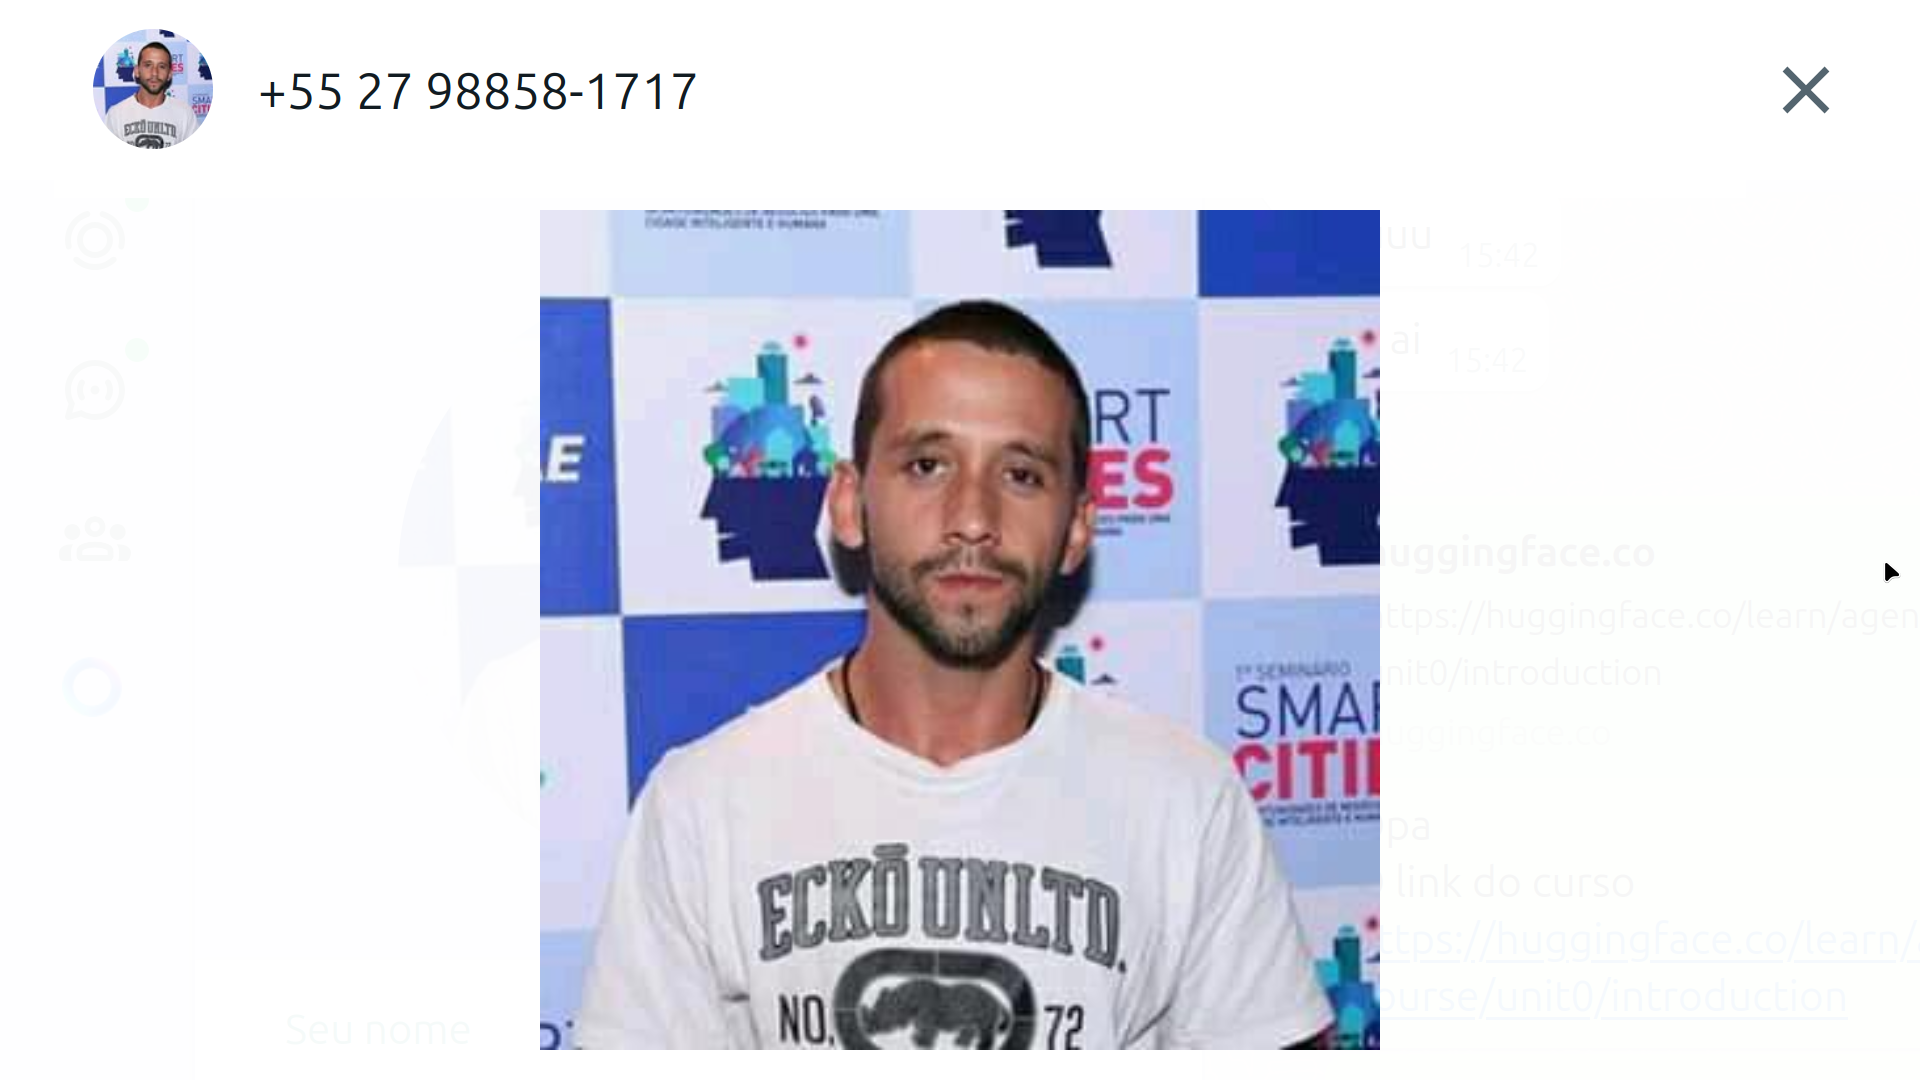